In [2]:
import os
import sys
from datetime import date
import random
import pandas as pd
from pathlib import Path
import numpy as np

from one.api import ONE

import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import accuracy
from torchmetrics import AUROC
import lightning as L 
from lightning.pytorch.utilities import CombinedLoader

from side_info_decoding.utils import (
    set_seed, 
    load_data_from_pids, 
    sliding_window_over_trials
)

seed = 666
set_seed(seed)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN3c106detail19maybe_wrap_dim_slowEllb
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from iblatlas.atlas import AllenAtlas
ba = AllenAtlas()
regions = np.unique(ba.regions.acronym[ba.regions.level == 7])
print(len(regions))

324


In [4]:
# setup
regions = ["LP", "GRN"]
n_sess = 10
out_path = Path("/mnt/3TB/yizi/cached_ibl_data")
one = ONE(base_url="https://openalyx.internationalbrainlab.org", mode='remote')

In [5]:
with open("../biorxiv_plots/regions.txt") as file:
    regions = [line.rstrip() for line in file]
print(len(regions))

76


In [ ]:
# download and cache data

for roi_idx, roi in enumerate(regions):
    
    print("=================")
    print(f"Downloading data in region {roi} ..")
    
    pids = one.search_insertions(atlas_acronym=[roi], query_type='remote')
    pids = list(pids)[:n_sess]
    
    # load choice
    neural_dict, choice_dict = load_data_from_pids(
        pids,
        brain_region=roi.lower(),
        behavior="choice",
        data_type="all_ks",
        n_t_bins = 40,
    )
    available_pids = list(neural_dict.keys())
    
    # load contrast
    _, contrast_dict = load_data_from_pids(
        pids,
        brain_region=roi.lower(),
        behavior="contrast",
        data_type="good_ks",
        n_t_bins = 40,
    )

    print("=================")
    print(f"Downloaded {len(available_pids)} PIDs in region {roi} ..")
    
    for _, pid in enumerate(available_pids):
        xs, ys = neural_dict[pid], choice_dict[pid]
        n_trials, n_units, n_t_bins = xs.shape
        if n_units < 5:
            continue
        xs = sliding_window_over_trials(xs, half_window_size=0).squeeze()
        ys = sliding_window_over_trials(ys, half_window_size=0).squeeze()
        xs, ys = torch.tensor(xs), torch.tensor(ys)
        
        contrast_dict[pid] = np.nan_to_num(contrast_dict[pid], 0)
        contrast_dict[pid].T[0] *= -1
        contrast = contrast_dict[pid].sum(1)
        
        # INCORPORATE CHANGE HERE!
        contrast_mask_dict = {}
        for lvl in np.unique(np.abs(contrast)):
            contrast_mask_dict.update(
                {lvl: np.argwhere(np.abs(contrast) == lvl).flatten()}
            )
            
        path = out_path/roi
        if not os.path.exists(path):
            os.makedirs(path)
            
        data_dict = {}
        data_dict.update({'contrast': contrast})
        data_dict.update({'contrast_mask': contrast_mask_dict})
        data_dict.update({'meta':
            {"n_trials": n_trials, "n_units": n_units, "n_t_bins": n_t_bins}
        })
        xs_per_lvl, ys_per_lvl = {}, {}
        xs_per_lvl.update({"all": xs})
        ys_per_lvl.update({"all": ys})
        for lvl in np.unique(np.abs(contrast)):
            try:
                xs_per_lvl.update({lvl: xs[contrast_mask_dict[lvl]]})
                ys_per_lvl.update({lvl: ys[contrast_mask_dict[lvl]]})
            except:
                continue
        data_dict.update({'neural_contrast': xs_per_lvl})
        data_dict.update({'choice_contrast': ys_per_lvl})
        np.save(path/f"pid_{pid}.npy", data_dict)
        
    print("=================")
    print(f"Successfully cached all data!")

In [6]:
class SessionDataset:
    def __init__(self, dataset, roi_idx, pid_idx, **kargs):
        self.xs, self.ys = dataset
        self.n_trials, self.n_units, _ = self.xs.shape
        self.roi_idx = roi_idx
        self.pid_idx = pid_idx
        
    def __len__(self):
        return self.n_trials
    
    def __getitem__(self, index):
        return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
    
def dataloader(datasets, roi_idxs, pid_idxs, batch_size=32): 
    loaders = []
    for i, dataset in enumerate(datasets):
        sess_dataset = SessionDataset(dataset, roi_idxs[i], pid_idxs[i])
        loaders.append(DataLoader(
            sess_dataset, batch_size = batch_size
        ))
    return loaders

class Hier_Reduced_Rank_Model(nn.Module):
    def __init__(
        self, 
        n_roi,
        n_units, 
        n_t_bin, 
        rank_V,
        rank_B
    ):
        super(Hier_Reduced_Rank_Model, self).__init__()
        
        self.n_roi = n_roi
        self.n_sess = len(n_units)
        self.n_units = n_units
        self.n_t_bin = n_t_bin
        self.rank_V = rank_V
        self.rank_B = rank_B
        
        self.Us = nn.ParameterList(
            [nn.Parameter(torch.randn(self.n_units[i], self.rank_V)) for i in range(self.n_sess)]
        )
        self.A = nn.Parameter(torch.randn(self.n_roi, self.rank_V, self.rank_B)) 
        self.B = nn.Parameter(
            torch.randn(self.rank_B, self.n_t_bin)
        ) 
        self.intercepts = nn.ParameterList(
            [nn.Parameter(torch.randn(1,)) for i in range(self.n_sess)]
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, datasets):
        pred_lst, gt_lst = [], []
        for dataset in datasets:
            X, Y, roi_idx, sess_idx = dataset
            roi_idx = torch.unique(roi_idx)
            sess_idx = torch.unique(sess_idx)
            n_trials, n_units, n_t_bins = X.shape
            self.Vs = torch.einsum("ijk,kt->ijt", self.A, self.B)
            self.Beta = torch.einsum("cr,rt->ct", self.Us[sess_idx], self.Vs[roi_idx].squeeze()).to(DEVICE)
            out = torch.einsum("ct,kct->k", self.Beta, X)
            out += self.intercepts[sess_idx].to(DEVICE) * torch.ones(n_trials).to(DEVICE)
            out = self.sigmoid(out)
            pred_lst.append(out)
            gt_lst.append(Y)
        return pred_lst, gt_lst
    
class LitHierRRR(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch):
        losses = 0
        pred_lst, gt_lst = self.model(batch)
        for i in range(len(batch)):
            losses += nn.BCELoss()(pred_lst[i], gt_lst[i])
        loss = losses / len(batch)
        self.log("loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        metrics = {"val_acc": np.mean(accs), "val_auc": np.mean(aucs)}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True)
    
    def test_step(self, batch):
        accs, aucs = self._shared_eval_step(batch)
        for i in range(len(batch)):
            print(f"session {i} test_acc {accs[i]} test_auc {aucs[i]}")

    def _shared_eval_step(self, batch):
        pred_lst, gt_lst = self.model(batch)
        accs, aucs = [], []
        for i in range(len(batch)):
            auroc = AUROC(task="binary")
            acc = accuracy(pred_lst[i], gt_lst[i], task="binary")
            auc = auroc(pred_lst[i], gt_lst[i])
            accs.append(acc)
            aucs.append(auc)
        return accs, aucs
        
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-2, weight_decay=1e-3)
        return optimizer

In [15]:
# setup
regions = ["LP", "GRN"]
n_rank_V = 5
n_rank_B = 5
n_epochs = 1000
in_path = Path("/mnt/3TB/yizi/cached_ibl_data")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


Started training on trials with contrast 0.0625 ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e59477-43f0-4441-9f81-3a55ddad9dad
df6012d0-d921-4d0a-af2a-2a91030d0f42
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
7332e6cf-9847-4aca-b2e3-d864989dd0fb
04c9890f-2276-4c20-854f-305ff5c9b6cf
6a098711-5423-4072-8909-7cff0e2d4531
39883ded-f5a2-4f4f-a98e-fb138eb8433e
aecd7612-b5c5-4ad2-9e76-e5b783387e47
2e720cee-05cc-440e-a24b-13794b1ac01d


/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
/tmp/ipykernel_112082/151427460.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  svd_Us = np.array(svd_Us)


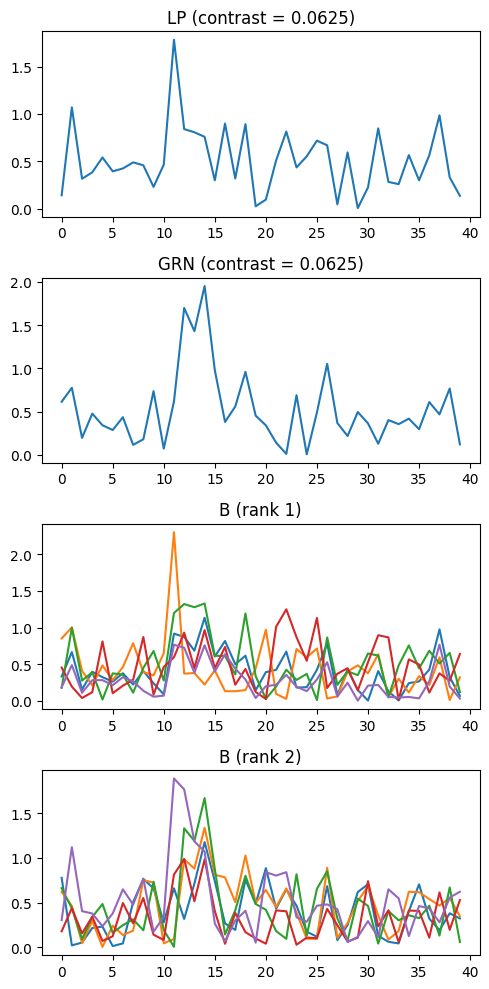

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)


Finished training on trials with contrast 0.0625 ..
Started training on 1 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e59477-43f0-4441-9f81-3a55ddad9dad
df6012d0-d921-4d0a-af2a-2a91030d0f42
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
7332e6cf-9847-4aca-b2e3-d864989dd0fb
04c9890f-2276-4c20-854f-305ff5c9b6cf
6a098711-5423-4072-8909-7cff0e2d4531
39883ded-f5a2-4f4f-a98e-fb138eb8433e
aecd7612-b5c5-4ad2-9e76-e5b783387e47
2e720cee-05cc-440e-a24b-13794b1ac01d


/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K

Accuracy:  [0.54838711 0.67741936 0.67741936 0.51612902 0.61290324 0.77419353
 0.64516127 0.67741936 0.54838711 0.61290324 0.85714287 0.80000001
 0.77142859 0.77142859 0.80000001 0.85714287 0.74285716 0.80000001
 0.77142859 0.74285716]
AUC:  [0.65909091 0.70454545 0.71363636 0.60454545 0.64545455 0.74545455
 0.66363636 0.69090909 0.63181818 0.64545455 0.90789474 0.90789474
 0.86184211 0.89473684 0.88157895 0.92434211 0.88157895 0.90460526
 0.85855263 0.89473684]
Finished training on 1 / 5 folds ..
Started training on 2 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K

Accuracy:  [0.61290324 0.61290324 0.61290324 0.61290324 0.61290324 0.64516127
 0.61290324 0.61290324 0.61290324 0.61290324 0.80000001 0.85714287
 0.82857144 0.88571429 0.88571429 0.77142859 0.88571429 0.85714287
 0.85714287 0.88571429]
AUC:  [0.45238095 0.44761905 0.48571429 0.47142857 0.46190476 0.45238095
 0.46666667 0.42857143 0.46666667 0.47619048 0.88815789 0.94736842
 0.90460526 0.93421053 0.92105263 0.91447368 0.91776316 0.92105263
 0.92434211 0.94078947]
Finished training on 2 / 5 folds ..
Started training on 3 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K

Accuracy:  [0.67741936 0.67741936 0.7096774  0.61290324 0.64516127 0.67741936
 0.7096774  0.67741936 0.67741936 0.64516127 0.88571429 0.91428572
 0.88571429 0.88571429 0.80000001 0.85714287 0.80000001 0.85714287
 0.82857144 0.85714287]
AUC:  [0.74285714 0.68095238 0.71428571 0.74285714 0.7047619  0.73809524
 0.72857143 0.71904762 0.74761905 0.74761905 0.92434211 0.89473684
 0.90789474 0.91447368 0.91118421 0.89802632 0.90460526 0.90789474
 0.93421053 0.90460526]
Finished training on 3 / 5 folds ..
Started training on 4 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 6.4 K 
--------------------------------------------------
6.4 K

Accuracy:  [0.61290324 0.7096774  0.67741936 0.67741936 0.74193549 0.7096774
 0.67741936 0.67741936 0.64516127 0.7096774  0.7647059  0.85294116
 0.82352942 0.82352942 0.7352941  0.85294116 0.79411763 0.82352942
 0.85294116 0.7647059 ]
AUC:  [0.72857143 0.79047619 0.72380952 0.73333333 0.77619048 0.76666667
 0.76190476 0.75238095 0.72380952 0.7952381  0.86315789 0.92982456
 0.8877193  0.9122807  0.87719298 0.92631579 0.90526316 0.91929825
 0.92982456 0.90175439]
Finished training on 4 / 5 folds ..
Started training on 5 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

/tmp/ipykernel_112082/2030879378.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.


Accuracy:  [0.63333333 0.66666669 0.63333333 0.60000002 0.66666669 0.63333333
 0.66666669 0.63333333 0.66666669 0.60000002 0.91176468 0.85294116
 0.85294116 0.7352941  0.82352942 0.79411763 0.7352941  0.82352942
 0.88235295 0.7647059 ]
AUC:  [0.565      0.505      0.495      0.555      0.525      0.56
 0.54       0.495      0.54       0.54       0.90972222 0.86805556
 0.87847222 0.84722222 0.85069444 0.80555556 0.84375    0.86111111
 0.875      0.81944444]
Finished training on 5 / 5 folds ..


In [16]:
# prep data for fitting hier-RRR on trials with diff contrast

res_dict = {}
# for lvl in ["all", .0625, .125, .25, 1.]:
for lvl in [.0625]:
    
    print("=================")
    print(f"Started training on trials with contrast {lvl} ..")

    lst_datasets, lst_units, lst_regions, lst_sessions, lst_region_names, lst_pids = [], [], [], [], [], []

    pid_idx = 0
    for roi_idx, roi in enumerate(regions):

        f_names = os.listdir(in_path/roi)
        pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names]

        print("=================")
        print(f"Loading {len(pids)} PIDs in region {roi}:")
        for pid in pids:
            print(pid)

        data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

        for _, pid in enumerate(pids):
            xs = data_dict["neural_contrast"][lvl]
            ys = data_dict["choice_contrast"][lvl]
            lst_datasets.append((xs, ys))
            lst_units.append(data_dict["meta"]["n_units"])
            lst_regions.append(roi_idx)
            lst_region_names.append(roi)
            lst_sessions.append(pid_idx)
            lst_pids.append(pid)
            pid_idx += 1 

    train_loaders = dataloader(lst_datasets, lst_regions, lst_sessions, batch_size=128)
    train_loaders = CombinedLoader(train_loaders, mode="min_size")

    hier_rrr = Hier_Reduced_Rank_Model(
        n_roi = len(regions),
        n_units = lst_units, 
        n_t_bin = data_dict["meta"]["n_t_bins"], 
        rank_V = n_rank_V,
        rank_B = n_rank_B
    )

    lit_hier_rrr = LitHierRRR(hier_rrr)
    trainer = L.Trainer(max_epochs=n_epochs)
    trainer.fit(model=lit_hier_rrr, 
                train_dataloaders=train_loaders)

    Us = [hier_rrr.Us[pid_idx].cpu().detach().numpy() for pid_idx in lst_sessions]
    Vs = hier_rrr.Vs.cpu().detach().numpy()
    B = hier_rrr.Vs.cpu().detach().numpy()

    svd_Us, svd_Vs = [], []
    for pid_idx in lst_sessions:
        roi_idx = lst_regions[pid_idx]
        W = Us[pid_idx] @ Vs[roi_idx]
        U, S, V = svd(W)
        svd_Vs.append(np.diag(S[:n_rank_V]) @ V[:n_rank_V, :])
        svd_Us.append(U[:, :n_rank_V] @ np.diag(S[:n_rank_V]))
    svd_Vs = np.array(svd_Vs)
    svd_Us = np.array(svd_Us)
    
    fig, axes = plt.subplots(len(regions)+2, 1, figsize=(5, 5*len(regions)))
    for i, roi_idx in enumerate(np.unique(lst_regions)):
        mask = np.array(lst_regions) == roi_idx
        axes[i].plot(np.abs(svd_Vs[mask].mean(0)[0]))
        axes[i].set_title(f"{regions[roi_idx]} (contrast = {lvl})")
    axes[2].plot(np.abs(B[0].T))
    axes[2].set_title("B (rank 1)")
    axes[3].plot(np.abs(B[1].T))
    axes[3].set_title("B (rank 2)")
    plt.tight_layout()
    plt.show()

    res_dict.update({lvl: {}})
    res_dict[lvl].update({"pid_idxs": lst_sessions})
    res_dict[lvl].update({"regions_idxs": lst_regions})
    res_dict[lvl].update({"region_names": lst_region_names})
    res_dict[lvl].update({"pids": lst_pids})
    res_dict[lvl].update({"svd_Vs": svd_Vs})
    res_dict[lvl].update({"svd_Us": svd_Us})
    res_dict[lvl].update({"B": B})
    res_dict[lvl].update({"S": S})
    
    print("=================")
    print(f"Finished training on trials with contrast {lvl} ..")
    
    # 5-fold CV
    n_folds = 5
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

    xval_dict = {}
    for fold_idx in range(n_folds):

        print("=================")
        print(f"Started training on {fold_idx+1} / {n_folds} folds ..")

        train_datasets, test_datasets = [], []
        lst_units, lst_regions, lst_sessions, lst_region_names, lst_pids = [], [], [], [], []

        pid_idx = 0
        for roi_idx, roi in enumerate(regions):

            f_names = os.listdir(in_path/roi)
            pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names]

            print("=================")
            print(f"Loading {len(pids)} PIDs in region {roi}:")
            for pid in pids:
                print(pid)

            data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

            for _, pid in enumerate(pids):
                xs = data_dict["neural_contrast"][lvl]
                ys = data_dict["choice_contrast"][lvl]
                for counter, (train, test) in enumerate(skf.split(xs, ys)):
                    if counter == fold_idx:
                        train_xs, test_xs = xs[train], xs[test]
                        train_ys, test_ys = ys[train], ys[test]
                train_datasets.append((train_xs, train_ys))
                test_datasets.append((test_xs, test_ys))
                lst_units.append(data_dict["meta"]["n_units"])
                lst_regions.append(roi_idx)
                lst_region_names.append(roi)
                lst_sessions.append(pid_idx)
                lst_pids.append(pid)
                pid_idx += 1

        train_loaders = dataloader(train_datasets, lst_regions, lst_sessions, batch_size=128)
        test_loaders = dataloader(test_datasets, lst_regions, lst_sessions, batch_size=128)
        train_loaders = CombinedLoader(train_loaders, mode="min_size")
        test_loaders = CombinedLoader(test_loaders, mode="min_size")

        hier_rrr = Hier_Reduced_Rank_Model(
            n_roi = len(regions),
            n_units = lst_units, 
            n_t_bin = data_dict["meta"]["n_t_bins"], 
            rank_V = n_rank_V,
            rank_B = n_rank_B
        ).to(DEVICE)

        lit_hier_rrr = LitHierRRR(hier_rrr)
        trainer = L.Trainer(max_epochs=n_epochs)
        trainer.fit(model=lit_hier_rrr, 
                    train_dataloaders=train_loaders)

        accs_per_batch, aucs_per_batch = [], []
        for batch in test_loaders:
            accs, aucs = [], []
            pred_lst, gt_lst = hier_rrr(batch[0])
            for i in range(len(batch[0])):
                auroc = AUROC(task="binary")
                accs.append(accuracy(pred_lst[i], gt_lst[i], task="binary").item())
                aucs.append(auroc(pred_lst[i], gt_lst[i]).item())
            accs_per_batch.append(accs)
            aucs_per_batch.append(aucs)
        test_accs = np.mean(accs_per_batch, 0)
        test_aucs = np.mean(aucs_per_batch, 0)
        print("Accuracy: ", test_accs)
        print("AUC: ", test_aucs)

        xval_dict.update({fold_idx: {}})
        xval_dict[fold_idx].update({"accs": test_accs})
        xval_dict[fold_idx].update({"aucs": test_aucs})
        xval_dict[fold_idx].update({"pid_idxs": lst_sessions})
        xval_dict[fold_idx].update({"regions_idxs": lst_regions})
        xval_dict[fold_idx].update({"region_names": lst_region_names})
        xval_dict[fold_idx].update({"pids": lst_pids})

        print("=================")
        print(f"Finished training on {fold_idx+1} / {n_folds} folds ..")

    np.save(in_path/f"xval_contrast_{lvl}.npy", xval_dict)
    
    break

# np.save(in_path/f"res_{date.today()}.npy", res_dict)

In [18]:
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.616989,0.629580
1,0.668817,0.625719
2,0.662151,0.626489
3,0.603871,0.621433
4,0.655914,0.622662
5,0.687957,0.652519
6,0.662366,0.632156
7,0.655699,0.617182
8,0.630108,0.621983
9,0.636129,0.640900


In [1]:
# eig = np.power(S, 2)
# print(eig / eig.sum())

In [16]:
n_rank_V = 10
n_rank_B = 10
n_epochs = 1000

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print(DEVICE)

cuda:0


In [18]:
# prep data for x-val

n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

xval_dict = {}
for fold_idx in range(n_folds):
    
    print("=================")
    print(f"Started training on {fold_idx+1} / {n_folds} folds ..")
    
    train_datasets, test_datasets = [], []
    lst_units, lst_regions, lst_sessions, lst_region_names, lst_pids = [], [], [], [], []

    pid_idx = 0
    for roi_idx, roi in enumerate(regions):

        f_names = os.listdir(in_path/roi)
        pids = [f_name.split("_")[1].split(".")[0] for f_name in f_names]

        print("=================")
        print(f"Loading {len(pids)} PIDs in region {roi}:")
        for pid in pids:
            print(pid)

        data_dict = np.load(in_path/roi/f"pid_{pid}.npy", allow_pickle=True).item()

        for _, pid in enumerate(pids):
            xs = data_dict["neural_contrast"]["all"]
            ys = data_dict["choice_contrast"]["all"]
            for counter, (train, test) in enumerate(skf.split(xs, ys)):
                if counter == fold_idx:
                    train_xs, test_xs = xs[train], xs[test]
                    train_ys, test_ys = ys[train], ys[test]
            train_datasets.append((train_xs, train_ys))
            test_datasets.append((test_xs, test_ys))
            lst_units.append(data_dict["meta"]["n_units"])
            lst_regions.append(roi_idx)
            lst_region_names.append(roi)
            lst_sessions.append(pid_idx)
            lst_pids.append(pid)
            pid_idx += 1
            
    train_loaders = dataloader(train_datasets, lst_regions, lst_sessions, batch_size=128)
    test_loaders = dataloader(test_datasets, lst_regions, lst_sessions, batch_size=128)
    train_loaders = CombinedLoader(train_loaders, mode="min_size")
    test_loaders = CombinedLoader(test_loaders, mode="min_size")

    hier_rrr = Hier_Reduced_Rank_Model(
        n_roi = len(regions),
        n_units = lst_units, 
        n_t_bin = data_dict["meta"]["n_t_bins"], 
        rank_V = n_rank_V,
        rank_B = n_rank_B
    ).to(DEVICE)

    lit_hier_rrr = LitHierRRR(hier_rrr)
    trainer = L.Trainer(max_epochs=n_epochs)
    trainer.fit(model=lit_hier_rrr, 
                train_dataloaders=train_loaders)
    
    accs_per_batch, aucs_per_batch = [], []
    for batch in test_loaders:
        accs, aucs = [], []
        pred_lst, gt_lst = hier_rrr(batch[0])
        for i in range(len(batch[0])):
            auroc = AUROC(task="binary")
            accs.append(accuracy(pred_lst[i], gt_lst[i], task="binary").item())
            aucs.append(auroc(pred_lst[i], gt_lst[i]).item())
        accs_per_batch.append(accs)
        aucs_per_batch.append(aucs)
    test_accs = np.mean(accs_per_batch, 0)
    test_aucs = np.mean(aucs_per_batch, 0)
    print("Accuracy: ", test_accs)
    print("AUC: ", test_aucs)
    
    xval_dict.update({fold_idx: {}})
    xval_dict[fold_idx].update({"accs": test_accs})
    xval_dict[fold_idx].update({"aucs": test_aucs})
    xval_dict[fold_idx].update({"pid_idxs": lst_sessions})
    xval_dict[fold_idx].update({"regions_idxs": lst_regions})
    xval_dict[fold_idx].update({"region_names": lst_region_names})
    xval_dict[fold_idx].update({"pids": lst_pids})
    
    print("=================")
    print(f"Finished training on {fold_idx+1} / {n_folds} folds ..")

np.save(in_path/f"xval_rankB_{n_rank_V}_rankV_{n_rank_V}.npy", xval_dict)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 12.8 K
--------------------------------------------------
12.8 K    Trainable params
0         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Started training on 1 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e59477-43f0-4441-9f81-3a55ddad9dad
df6012d0-d921-4d0a-af2a-2a91030d0f42
cc72fdb7-92e8-47e6-9cea-94f27c0da2d8
7332e6cf-9847-4aca-b2e3-d864989dd0fb
04c9890f-2276-4c20-854f-305ff5c9b6cf
6a098711-5423-4072-8909-7cff0e2d4531
39883ded-f5a2-4f4f-a98e-fb138eb8433e
aecd7612-b5c5-4ad2-9e76-e5b783387e47
2e720cee-05cc-440e-a24b-13794b1ac01d


/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_102572/2477955401.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but 

Accuracy:  [0.84375    0.84375    0.85546875 0.859375   0.84765625 0.859375
 0.85546875 0.8515625  0.85546875 0.859375   0.953125   0.8342014
 0.88975695 0.8858507  0.88975695 0.83810765 0.94921875 0.8936632
 0.89756945 0.94921875]
AUC:  [0.38500669 0.38821954 0.38674699 0.38299866 0.38447122 0.38527443
 0.38781794 0.38661312 0.38567604 0.38607764 0.98336188 0.94948268
 0.9498497  0.94899332 0.949238   0.94960502 0.98409591 0.98519697
 0.94813695 0.98409591]
Finished training on 1 / 5 folds ..
Started training on 2 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c87

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_102572/2477955401.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but ha

Accuracy:  [0.8359375  0.83203125 0.8203125  0.8359375  0.8359375  0.828125
 0.82421875 0.828125   0.828125   0.83203125 0.9453125  0.9375
 0.94140625 0.93359375 0.9453125  0.94140625 0.94140625 0.9375
 0.94140625 0.94140625]
AUC:  [0.34703075 0.34544008 0.34424708 0.33722163 0.3400053  0.33947508
 0.3468982  0.34597031 0.33987275 0.34663309 0.97936625 0.97555883
 0.97678703 0.97408499 0.97973471 0.98157701 0.98255957 0.97764677
 0.97899779 0.97936625]
Finished training on 2 / 5 folds ..
Started training on 3 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e5

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_102572/2477955401.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but ha

Accuracy:  [0.35546875 0.35546875 0.35546875 0.35546875 0.35546875 0.35546875
 0.35546875 0.35546875 0.35546875 0.35546875 0.96484375 0.96484375
 0.96484375 0.96484375 0.96484375 0.96484375 0.96484375 0.96484375
 0.96484375 0.96484375]
AUC:  [0.39912513 0.39899258 0.39899258 0.39925769 0.39912513 0.39925769
 0.39899258 0.39793213 0.39886002 0.39939024 0.99606976 0.99582412
 0.99582412 0.99582412 0.99582412 0.99582412 0.99582412 0.99582412
 0.99582412 0.99582412]
Finished training on 3 / 5 folds ..
Started training on 4 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_102572/2477955401.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                    | Params
--------------------------------------------------
0 | model | Hier_Reduced_Rank_Model | 12.8 K
--------------------------------------------------
12.8 

Accuracy:  [0.7421875 0.7421875 0.7421875 0.7421875 0.7421875 0.7421875 0.7421875
 0.7421875 0.7421875 0.7421875 0.90625   0.9140625 0.90625   0.890625
 0.90625   0.8984375 0.9140625 0.90625   0.90625   0.90625  ]
AUC:  [0.81521739 0.81601273 0.81495228 0.8154825  0.81442206 0.8154825
 0.81601273 0.81495228 0.81574761 0.81495228 0.96525569 0.96452165
 0.96525569 0.9696599  0.96550037 0.96354294 0.9640323  0.96256423
 0.96525569 0.96525569]
Finished training on 4 / 5 folds ..
Started training on 5 / 5 folds ..
Loading 10 PIDs in region LP:
a6b71993-165b-4c43-845c-c062fe7d7a11
ec2fbc3e-cb2b-48cb-a521-3a6ca15e244c
bef05a5c-68c3-4513-87c7-b3151c88da8e
7a620688-66cb-44d3-b79b-ccac1c8ba23e
d0046384-16ea-4f69-bae9-165e8d0aeacf
8c732bf2-639d-496c-bf82-464bc9c2d54b
b72b22c2-6e9d-4604-9910-20c0e1a467d7
8b31b4bd-003e-4816-a3bf-2df4cc3558f8
1a924329-65aa-465d-b201-c2dd898aebd0
22f26d69-0b30-450e-9618-ee801b720e0a
Loading 10 PIDs in region GRN:
e17db2b6-b778-4e2a-845c-c4d040b0c875
c0e59477-43f0-444

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                               | 0/? [00:00<?, ?it/s]

/tmp/ipykernel_102572/2477955401.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.xs[index]).to(DEVICE), torch.tensor(self.ys[index]).to(DEVICE), self.roi_idx, self.pid_idx
`Trainer.fit` stopped: `max_epochs=1000` reached.


Accuracy:  [0.75      0.75      0.75      0.75      0.75      0.75      0.75
 0.75      0.75      0.75      0.953125  0.9609375 0.953125  0.953125
 0.953125  0.9609375 0.953125  0.953125  0.953125  0.9609375]
AUC:  [0.81866384 0.81813362 0.81919406 0.81919406 0.81919406 0.81892895
 0.81892895 0.81813362 0.81839873 0.81892895 0.96838235 0.97377451
 0.96936275 0.96862745 0.96838235 0.97034314 0.96862745 0.96887255
 0.96911765 0.97303922]
Finished training on 5 / 5 folds ..


In [19]:
# V = 10, B = 10
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.705469,0.553009
1,0.704688,0.553360
2,0.704688,0.552827
3,0.708594,0.550831
4,0.706250,0.551444
5,0.707031,0.551684
6,0.705469,0.553730
7,0.705469,0.552720
8,0.706250,0.551711
9,0.707813,0.553196


In [15]:
# V = 10, B = 5
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.703125,0.532945
1,0.700781,0.533767
2,0.702344,0.534322
3,0.700781,0.532731
4,0.702344,0.533686
5,0.701562,0.534217
6,0.701562,0.533262
7,0.700781,0.533476
8,0.701562,0.533316
9,0.708594,0.533023


In [11]:
# V = 5, B = 5
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.810937,0.543453
1,0.810937,0.544408
2,0.814063,0.544170
3,0.810937,0.544090
4,0.812500,0.545203
5,0.811719,0.544225
6,0.812500,0.543878
7,0.810937,0.543798
8,0.813281,0.542712
9,0.809375,0.544412


In [85]:
# V = 2, B = 10
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.683594,0.508111
1,0.682813,0.507580
2,0.684375,0.509303
3,0.682813,0.509489
4,0.687500,0.507819
5,0.688281,0.508720
6,0.684375,0.508508
7,0.681250,0.508349
8,0.682813,0.507686
9,0.685156,0.508110


In [81]:
# V = 2, B = 5
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.696875,0.528527
1,0.696875,0.528421
2,0.696875,0.528554
3,0.696875,0.528554
4,0.696875,0.528474
5,0.696875,0.528633
6,0.694531,0.527563
7,0.696875,0.528528
8,0.696875,0.528580
9,0.696875,0.528421


In [76]:
# V = 2, B = 2
df = pd.DataFrame(xval_dict[0]).iloc[:,:2] / 5
for fold in range(1,5):
    df += pd.DataFrame(xval_dict[fold]).iloc[:,:2] / 5
df

,accs,aucs
0,0.682813,0.502315
1,0.682813,0.502288
2,0.682813,0.501693
3,0.682031,0.502103
4,0.678906,0.501462
5,0.681250,0.500805
6,0.681250,0.499776
7,0.681250,0.501623
8,0.678125,0.498670
9,0.684375,0.502397
